## Day 18: Applications to Image Compression

In this notebook, we work through a practical example of change of basis. We'll look at the standard basis for *color space* (RGB) and find an alternative that packs the majority of the image information into a single basis vector (the chrominance/luminance scale).

We'll then utilize another change of basis over spatial dimensions of the image (as opposed to the color dimensions). We'll explore the Discrete Cosine Transform, a Fourier-like transform, which will allow us to find opportunities to reduce the size of an image by zeroing out many of the elements in the array that stores the image.

This notebook is set up to use an image of our School of Engineering, Technology, and Aeronautics building but you can feel free to change the link to an image you'd prefer to work with. If your image is of a different size, you may need to adjust the locations of the focal points through the first part of the activity.

We'll start by loading the necessary Python modules, reading in the image, and plotting it.

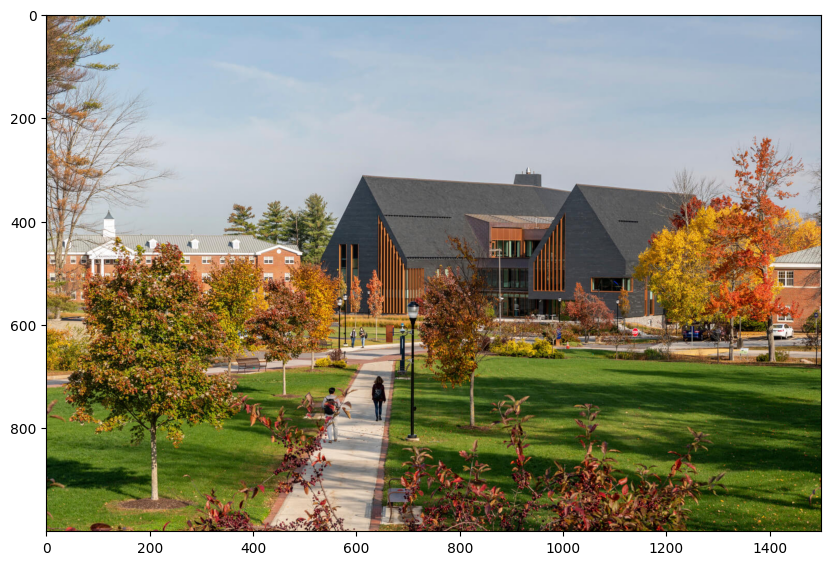

In [ ]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.image as mpimp

import urllib.request
from PIL import Image

import cv2

url = "https://raw.githubusercontent.com/agmath/agmath.github.io/master/SiteFiles/SETA_building.jpg"
seta_img = np.array(Image.open(urllib.request.urlopen(url)))

plt.figure(figsize=(10, 10))
plt.imshow(seta_img)
plt.show()

> **Note:** This notebook uses `{numpy}` instead of `{sympy}` because we are focused on numeric calculations. The work is easier to do with `{numpy}` objects. There are a few things you should know.
>
> 1. To compute a matrix product $AB$ in `{numpy}`, we use `np.matmul(A, B)`.
> 2. To calculate the inverse of a matrix $A$ in `{numpy}`, we use `np.linalg.inv(A)`.
> 3. To build the transpose of a matrix $A$ in `{numpy}`, we use `A.T`

Use the `.shape` attribute of the image object to identify the shape of the array used to store the image. Discuss why the image array has this shape.

This is quite a bit of data to store -- each element in this image array is an 8-bit integer. Use the code cell below to approximate the size of the image if stored as a full collection of RGB values.


We'll focus in on a few small regions in the first part of this notebook. In particular, the JPEG compression algorithm loops over $8\times 8$ pixel blocks in an image when running, so we'll look at a pair of $8\times 8$ blocks. You can (and should!) this notebook with different choices of pixel blocks. You can make those changes by altering the lower-left coordinates of the pixel blocks below.

In [ ]:
box1_low_left = [400, 565]
box2_low_left = [680, 1000]

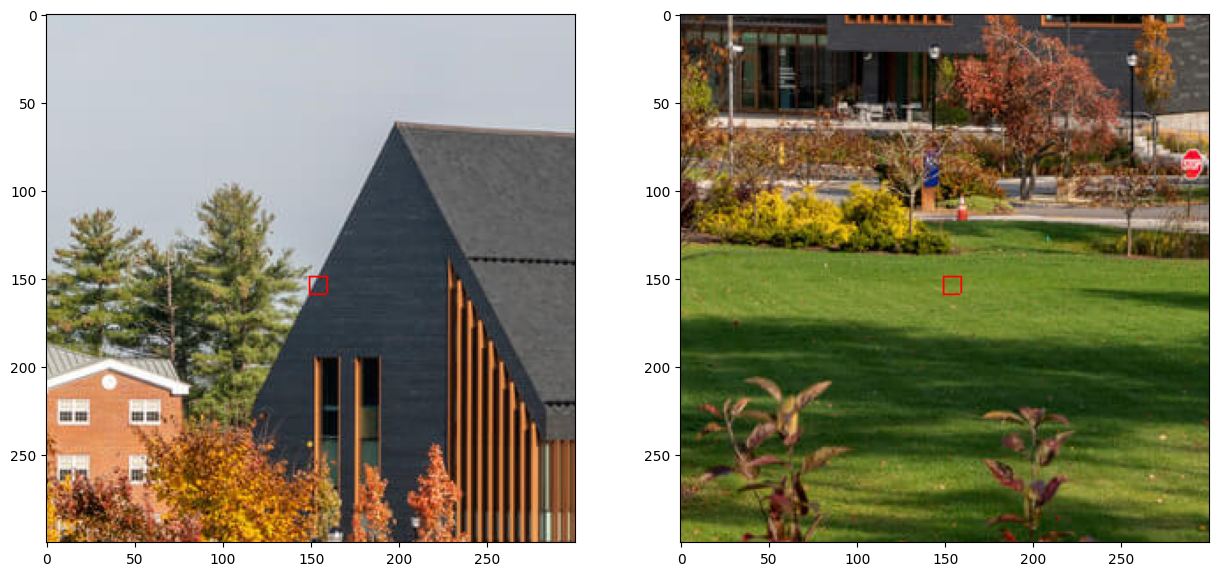

In [ ]:
# @title

##Adapt plotting code to always return image of the same dimensions,
##even if the selected box is near a corner. Add left-over pixels
##to the other "side" if too close to the edge.
seta_img_copy = seta_img.copy()

seta_img_copy[(box1_low_left[0] - 1):(box1_low_left[0] + 9), box1_low_left[1] - 1, 0] = 255
seta_img_copy[(box1_low_left[0] - 1):(box1_low_left[0] + 9), box1_low_left[1] - 1, 1] = 0
seta_img_copy[(box1_low_left[0] - 1):(box1_low_left[0] + 9), box1_low_left[1] - 1, 2] = 0

seta_img_copy[(box1_low_left[0] - 1):(box1_low_left[0] + 9), box1_low_left[1] + 9, 0] = 255
seta_img_copy[(box1_low_left[0] - 1):(box1_low_left[0] + 9), box1_low_left[1] + 9, 1] = 0
seta_img_copy[(box1_low_left[0] - 1):(box1_low_left[0] + 9), box1_low_left[1] + 9, 2] = 0

seta_img_copy[box1_low_left[0] - 1, (box1_low_left[1] - 1):(box1_low_left[1] + 9), 0] = 255
seta_img_copy[box1_low_left[0] - 1, (box1_low_left[1] - 1):(box1_low_left[1] + 9), 1] = 0
seta_img_copy[box1_low_left[0] - 1, (box1_low_left[1] - 1):(box1_low_left[1] + 9), 2] = 0

seta_img_copy[box1_low_left[0] + 9, (box1_low_left[1] - 1):(box1_low_left[1] + 9), 0] = 255
seta_img_copy[box1_low_left[0] + 9, (box1_low_left[1] - 1):(box1_low_left[1] + 9), 1] = 0
seta_img_copy[box1_low_left[0] + 9, (box1_low_left[1] - 1):(box1_low_left[1] + 9), 2] = 0

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(seta_img_copy[(box1_low_left[0] - min(150, box1_low_left[0])):(box1_low_left[0] + min(150, 1000 - box1_low_left[0])), (box1_low_left[1] - min(150, box1_low_left[0])):(box1_low_left[1] + min(150, 1500 - box1_low_left[1])), :])

plt.subplot(1, 2, 2)
seta_img_copy = seta_img.copy()

seta_img_copy[(box2_low_left[0] - 1):(box2_low_left[0] + 9), box2_low_left[1] - 1, 0] = 255
seta_img_copy[(box2_low_left[0] - 1):(box2_low_left[0] + 9), box2_low_left[1] - 1, 1] = 0
seta_img_copy[(box2_low_left[0] - 1):(box2_low_left[0] + 9), box2_low_left[1] - 1, 2] = 0

seta_img_copy[(box2_low_left[0] - 1):(box2_low_left[0] + 9), box2_low_left[1] + 9, 0] = 255
seta_img_copy[(box2_low_left[0] - 1):(box2_low_left[0] + 9), box2_low_left[1] + 9, 1] = 0
seta_img_copy[(box2_low_left[0] - 1):(box2_low_left[0] + 9), box2_low_left[1] + 9, 2] = 0

seta_img_copy[box2_low_left[0] - 1, (box2_low_left[1] - 1):(box2_low_left[1] + 9), 0] = 255
seta_img_copy[box2_low_left[0] - 1, (box2_low_left[1] - 1):(box2_low_left[1] + 9), 1] = 0
seta_img_copy[box2_low_left[0] - 1, (box2_low_left[1] - 1):(box2_low_left[1] + 9), 2] = 0

seta_img_copy[box2_low_left[0] + 9, (box2_low_left[1] - 1):(box2_low_left[1] + 9), 0] = 255
seta_img_copy[box2_low_left[0] + 9, (box2_low_left[1] - 1):(box2_low_left[1] + 9), 1] = 0
seta_img_copy[box2_low_left[0] + 9, (box2_low_left[1] - 1):(box2_low_left[1] + 9), 2] = 0


plt.imshow(seta_img_copy[(box2_low_left[0] - min(150, box2_low_left[0])):(box2_low_left[0] + min(150, 1000 - box2_low_left[0])), (box2_low_left[1] - min(150, box2_low_left[0])):(box2_low_left[1] + min(150, 1500 - box2_low_left[1])), :])

plt.show()

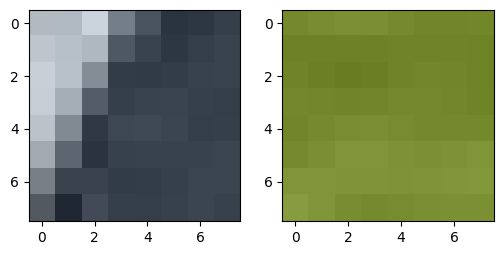

In [ ]:
# @title
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.imshow(seta_img[box1_low_left[0]:(box1_low_left[0] + 8), box1_low_left[1]:(box1_low_left[1] + 8), :])

plt.subplot(1, 2, 2)
plt.imshow(seta_img[box2_low_left[0]:(box2_low_left[0] + 8), box2_low_left[1]:(box2_low_left[1] + 8), :])

plt.show()

In the original RGB encoding of the image, the pixel coloration information is split nearly equally across the three dimensions. It would be better if we could pack a large amount of the information into a single dimension, while the other two dimensions are less influential. Achieving this would allow us to prioritize what information is kept and be more loose about what is dropped from the remaining color dimensions. We'll achieve this through a basis conversion from RGB-scale to the *luminance/chrominance* scale.

A few notes about converting to *luminance / chrominance* here...

1. We've changed bases, so the new image encoding is no longer on the RGB scale and we can't treat it that way -- see the top-left plot.
2. Luminance carries the most important visual information, as can be seen in the top-right plot.
3. The blue and red chrominance carry the remaining information required to construct the image -- they are still plotted in greyscale so that you can better see the information carried by these channels but you can view the code to comment out the existing plots and uncomment the plots that use blues and reds if you want to see colored versions of those plots.

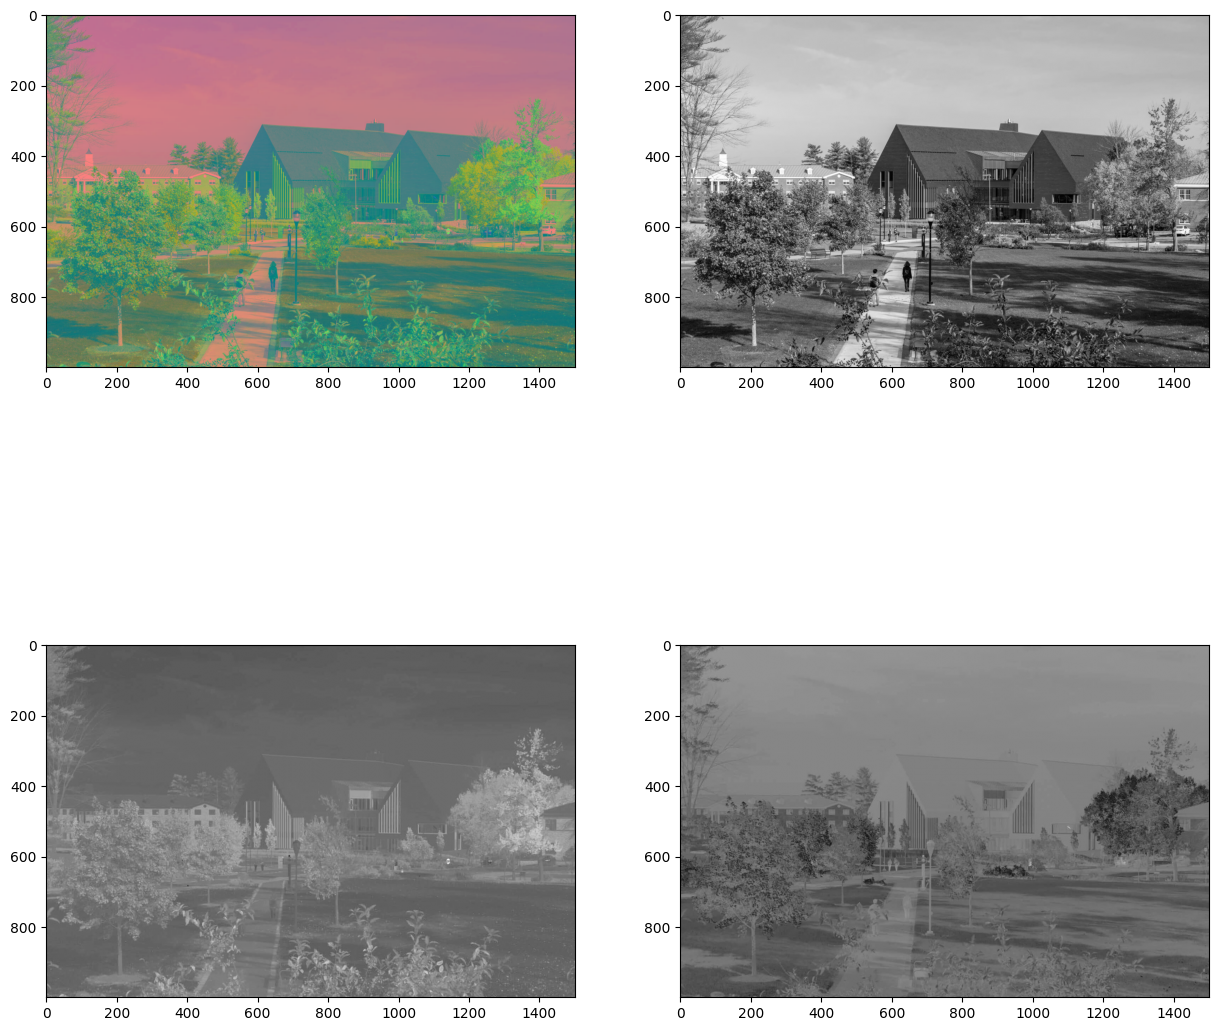

In [ ]:
# @title
#Convert Image to luminance / chrominance...
ycbcr_seta_img = cv2.cvtColor(seta_img, cv2.COLOR_RGB2YCrCb)

plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.imshow(ycbcr_seta_img)

plt.subplot(2, 2, 2)
plt.imshow(ycbcr_seta_img[:, :, 0], cmap='gray')

plt.subplot(2, 2, 3)
plt.imshow(ycbcr_seta_img[:, :, 1], cmap='gray')
#plt.imshow(ycbcr_seta_img[:, :, 1], cmap='Blues')

plt.subplot(2, 2, 4)
plt.imshow(ycbcr_seta_img[:, :, 2], cmap='gray')
#plt.imshow(ycbcr_seta_img[:, :, 2], cmap='Reds')

plt.show()

Let's see our original blocks, but view them through the luminance channel only.

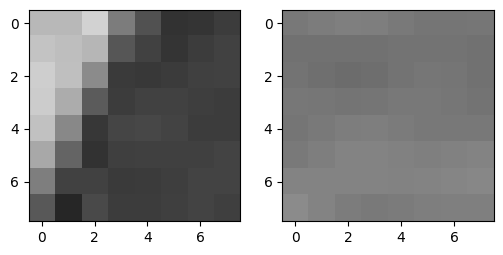

In [ ]:
# @title
block_a_lum = ycbcr_seta_img[box1_low_left[0]:(box1_low_left[0] + 8), box1_low_left[1]:(box1_low_left[1] + 8), 0]
block_b_lum = ycbcr_seta_img[box2_low_left[0]:(box2_low_left[0] + 8), box2_low_left[1]:(box2_low_left[1] + 8), 0]

plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.imshow(block_a_lum, cmap = "gray", vmin = 0, vmax = 255)

plt.subplot(1, 2, 2)
plt.imshow(block_b_lum, cmap = "gray", vmin = 0, vmax = 255)

plt.show()

Just and outline for now...

+ The image above is 1000 pixels tall by 1500 pixels wide.
+ Storing this image via RGB pixel color values would require storing 3\*1000\*1500 = 4.5 million integers.
+ These integers are 8-bit integers, so the image stored in full would require 36 million bits, or about 4.5 megabytes.
+ There is lots of redundancy across the image. The sky, clouds, actual SETA building, grass, have large swaths of largely constant color. Storing information for every pixel in these regions is unnecessary and redundant.
+ Bases for *color-space* -- 3-dimensional space

  + *additive scale* RGB provides one possible basis
  + *subtractive scale* CMY provides another possible basis
  +  *luminance/chrominance* model ($YC_rC_b$) is a third possible basis (and there are others too).
  + **Note:** There is theoretical rationale for color space having three dimensions. The human eye includes three types of cone cells, each sensitive to different wavelengths of light (red, green, and blue). VERIFY this...the textbook suggests that $YC_bC_r$ is the scheme most related to the human eye!

+ Call RGB the *standard color basis* with $\vec{r} = \begin{bmatrix} 1\\ 0\\ 0\end{bmatrix}$, $\vec{g} = \begin{bmatrix} 0\\ 1\\ 0\end{bmatrix}$, and $\vec{b} = \begin{bmatrix} 0\\ 0\\ 1\end{bmatrix}$.
+ The *luminance/chrominance* basis is $\vec{Y} = \begin{bmatrix} 1\\ 1\\ 1\end{bmatrix}$, $\vec{C_b} = \begin{bmatrix} 0\\ -0.34413\\ 1.77200\end{bmatrix}$, and $\vec{C_r} = \begin{bmatrix} 1.40200\\ -0.71414\\ 0\end{bmatrix}$.
+ JPEG compression algorithm converts from RGB to $YC_bC_r$ to take advantage of the fact that *luminance* ($Y$) stores the most visually important information, determining the sharpness of the image.

### JPEG Compression Algorithm

+ We want to detect redundancies in the data.

  + Add the images with boxes and the 8x8 plots here...

+ The JPEG compression algorithm involves two changes of basis. It may be helpful to think of our image as a 3-dimensional tensor (three matrices placed one on top of the other). First, we change the basis along the *depth* of the tensor. Doing so moves us from RGB scale to $YC_bC_r$ scale. Next, we perform a change of basis along a different dimension.
+ We'll work with $8\times 8$ pixel arrays.

In [ ]:
ycbcr_seta_img[0:8, 0:8, 0]

array([[101, 102,  94, 104,  77,  51,  88, 109],
       [105, 102,  74,  71,  65,  62,  93, 107],
       [ 68,  84,  66,  64,  81,  83,  91,  97],
       [ 64,  75,  52,  46,  73,  84, 100, 132],
       [ 68,  65,  52,  61,  94,  95,  90, 123],
       [ 68,  56,  65,  93, 124, 109,  70,  78],
       [ 77,  61,  74,  82,  93,  96,  77,  88],
       [ 45,  53,  94,  91,  77,  86,  83,  96]], dtype=uint8)

+ We'll perform our second change of basis on the columns of these $8\times 8$ blocks.
+ We make use of the notion that the coordinates of a vector in the standard basis ($\vec{x}$) can be obtained from the alternative basis coordinates of the vector ($\left[\vec{x}\right]_{\mathscr{B}}$, referred to as $\vec{f}$ here for convenience). We construct a matrix $P$ whose columns are the vectors in this new basis, and then we notice that $\vec{x} = P\vec{f}$. This also means that $\vec{f} = P^{-1}\vec{x}$.
+ Note that $P^{-1}$ must exist, since it is constructed using basis vectors as its columns.

+ We'll perform the change of basis and then describe each column of pixels in this block using the average luminance along with information about how the values vary from the average.

  + We remain focused on the $Y$ (luminance) channel here and ignore chrominance.
+ Textbook mentions that we'll use the *discrete fourier transform*, but we are actually using the *discrete cosine transform*.
+ Our basis vectors are $\left\{\vec{v_0},~\vec{v_1},~\cdots,~\vec{v_7}\right\}$, taking the form
$$\vec{v_i} = \begin{bmatrix} \cos\left(\frac{\left(2\cdot \left(0\right) + 1\right)\cdot i\pi}{16}\right)\\
\cos\left(\frac{\left(2\cdot \left(1\right) + 1\right)\cdot i\pi}{16}\right)\\
\cos\left(\frac{\left(2\cdot \left(2\right) + 1\right)\cdot i\pi}{16}\right)\\
\vdots\\
\cos\left(\frac{\left(2\cdot \left(7\right) + 1\right)\cdot i\pi}{16}\right)\\
\end{bmatrix}$$

Notice that the $\vec{v_i}$ vectors form a basis for $\mathbb{R}^8$. Let's visualize the components of these basis vectors.

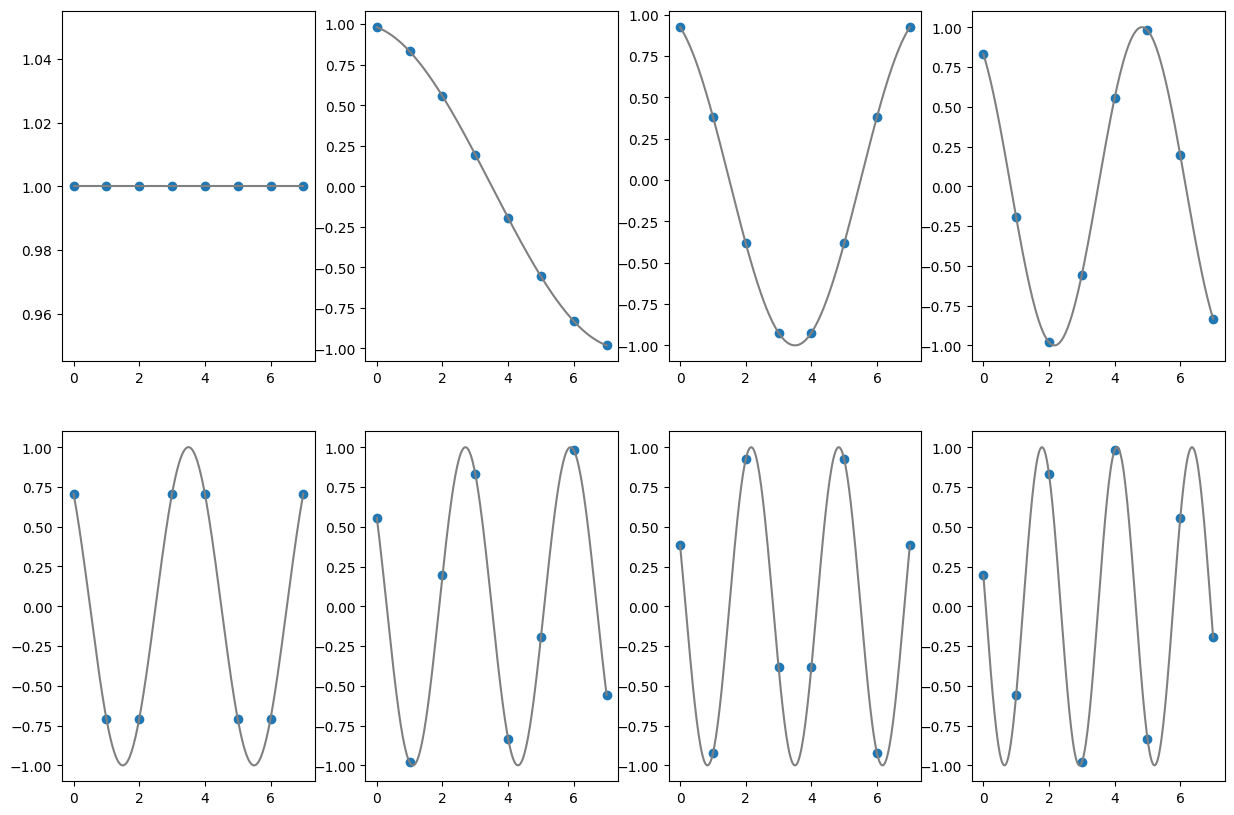

In [ ]:
# @title
P = np.zeros((8, 8))
x_vals = np.linspace(0, 7, 250)
y_vals = np.zeros((len(x_vals), 8))

for i in list(range(0, 8)):
  for j in list(range(0, 8)):
    P[i, j] = np.cos((2*i + 1)*j*np.pi/16)

  y_vals[:, i]= np.cos((2*x_vals + 1)*i*np.pi/16)


plt.figure(figsize=(15, 10))
for i in list(range(0, 8)):
  plt.subplot(2, 4, i + 1)
  plt.plot(x_vals, y_vals[:, i], color = "grey")
  plt.scatter(x = list(range(0, 8)), y = P[:, i])

plt.show()

Notice that the entries of $\vec{v_1}$ don't vary at all, the entries of $\vec{v_2}$ vary slowly, and the enries of $\vec{v_i}$ vary more quickly as $i$ increases towards $7$.

The idea is that, if there is not much variability in the vector of luminance values, the coefficients on the vectors that permit lots of variance will be near $0$. If there is lots of variability in those columns, then the coefficients permitting the variation will be larger (in absolute value), contributing more information about the column vector $\vec{x}$.

Now that we have this new basis, we can collect the vectors into a matrix $P$ and use the relationships that $\vec{x} = P\vec{f}$ and $P^{-1}\vec{x} = \vec{f}$, where $\vec{f}$ is the vector of discrete cosine transform coefficients.

The code block above actually created the matrix of discrete cosine transformation basis vectors `P`. Use the code block below to print out that matrix, to calculate (and store) its inverse, and then print out the inverse as well.

Notice that the first row of $P^{-1}$ consists of a constant $1/8$. This means that, when we multiply $P^{-1}\vec{x}$, the first element of $\vec{f}$ will be the average luminance over the column.

Let's bring back those two $8\times 8$ blocks of pixels we investigated earlier. As a reminder, they appear below -- the original RGB-scale images appear in the top row, while just the luminance is being displayed in the bottom row.

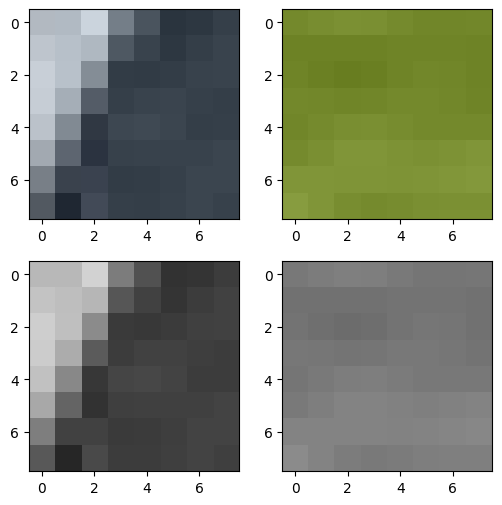

In [ ]:
# @title
block_a = seta_img[box1_low_left[0]:(box1_low_left[0] + 8), box1_low_left[1]:(box1_low_left[1] + 8), :]
block_b = seta_img[box2_low_left[0]:(box2_low_left[0] + 8), box2_low_left[1]:(box2_low_left[1] + 8), :]

plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.imshow(block_a)

plt.subplot(2, 2, 2)
plt.imshow(block_b)

plt.subplot(2, 2, 3)
plt.imshow(block_a_lum, cmap = "gray", vmin = 0, vmax = 255)

plt.subplot(2, 2, 4)
plt.imshow(block_b_lum, cmap = "gray", vmin = 0, vmax = 255)

plt.show()

Let's now transform the luminance blocks into the space defined by the *discrete cosine transform* basis. We'll round to integer values since we know we're going to store our resulting image using integers as well. As a reminder, we have the relationships $\vec{x} = P\vec{f}$ and $P^{-1}\vec{x} = \vec{f}$, where $\vec{x}$ is the position of a vector in the initial basis and $\vec{f}$ is the position of the vector relative to the new basis. We can also define this relationship for full matrices (blocks of pixels), so that $X = PF$ and $P^{-1}X = F$, where $X$ is the block of pixels where columns are conveyed in the original basis and $F$ is the block in which the columns of pixels are written using the new basis.

Use the code block below to calculate and print out the transformed blocks. Call the results `transformed_block_a` and `transformed_block_b`. There are a few helpful things to know -- (i) `np.round(val, decimal_places)` can be used for rounding, (ii) `np.matmul(A, B)` is used to compute the matrix-product $AB$, and you can use `block_a[:, :, 0]` to extract only the luminance "layer" from the image block `block_a`.

Transformed block A:
 [[165. 128. 101.  64.  57.  53.  54.  56.]
 [ 44.  76.  72.  20.   5.  -6.  -5.  -1.]
 [-34. -23.  37.  15.   2.  -5.  -1.   1.]
 [  6.  -3.  -4.  14.   7.  -1.  -3.   0.]
 [ -5.  -3.  -1.   9.   6.   1.  -2.  -3.]
 [  0.   2.   2.  -0.  -0.  -0.   0.  -0.]
 [  0.   0.  -0.  -0.  -0.  -0.   0.   0.]
 [  0.  -0.   0.   0.   0.  -0.  -0.   0.]]
Transformed block B:
 [[118. 118. 118. 118. 118. 118. 118. 118.]
 [ -9.  -8.  -7.  -6.  -6.  -7.  -8.  -9.]
 [  6.   5.   3.   1.   0.   1.   2.   3.]
 [ -2.   3.   9.   9.   4.   1.   2.   4.]
 [  2.   2.   1.   1.  -0.  -1.  -2.  -3.]
 [  2.   2.   2.   2.   2.   2.   2.   2.]
 [  0.  -0.   0.  -0.  -0.   0.   0.   0.]
 [ -0.  -0.  -0.   0.  -0.  -0.   0.  -0.]]


Notice that in the transformed version of Block A there is quite a bit of variation down each column. In Block B, however, there is much less variation.

Let's dismiss small components in these transformed matrices. We'll zero-out any entries whose absolute value is at most 10.

In [ ]:
transformed_block_a[abs(transformed_block_a) <= 10] = 0
transformed_block_b[abs(transformed_block_b) <= 10] = 0

print("Compressed Transformed Block A:\n", transformed_block_a)
print("Compressed Transformed Block B:\n", transformed_block_b)

Compressed Transformed Block A:
 [[165. 128. 101.  64.  57.  53.  54.  56.]
 [ 44.  76.  72.  20.   0.   0.   0.   0.]
 [-34. -23.  37.  15.   0.   0.   0.   0.]
 [  0.   0.   0.  14.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]]
Compressed Transformed Block B:
 [[118. 118. 118. 118. 118. 118. 118. 118.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]]


Use the code block below to transform back to luminance values. As a reminder, we still have the relationships $X = PF$ and $P^{-1}X = F$. Call your results `block_a_est` and `block_b_est`.

Now that you've transformed the image blocks back to the luminance values, I'll plot them for you below.

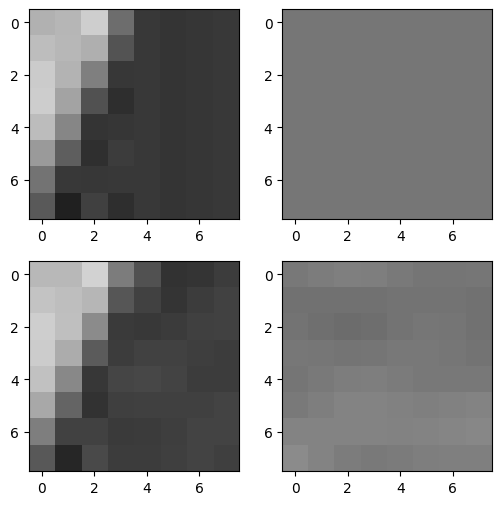

In [ ]:
# @title
plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.imshow(block_a_est, cmap = "gray", vmin = 0, vmax = 255)

plt.subplot(2, 2, 2)
plt.imshow(block_b_est, cmap = "gray", vmin = 0, vmax = 255)

plt.subplot(2, 2, 3)
plt.imshow(block_a_lum, cmap = "gray", vmin = 0, vmax = 255)

plt.subplot(2, 2, 4)
plt.imshow(block_b_lum, cmap = "gray", vmin = 0, vmax = 255)

plt.show()

Can you even tell that the estimated blocks are plotted on top and the originals are on bottom? Let's see what happens if we utilize heavier compression. Instead of using 2 as our threshold for zeroing-out entries, let's use 20.

Compressed Transformed Block A:
 [[165. 128. 101.  64.  57.  53.  54.  56.]
 [ 44.  76.  72.   0.   0.   0.   0.   0.]
 [-34. -23.  37.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]]
Compressed Transformed Block B:
 [[118. 118. 118. 118. 118. 118. 118. 118.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]]


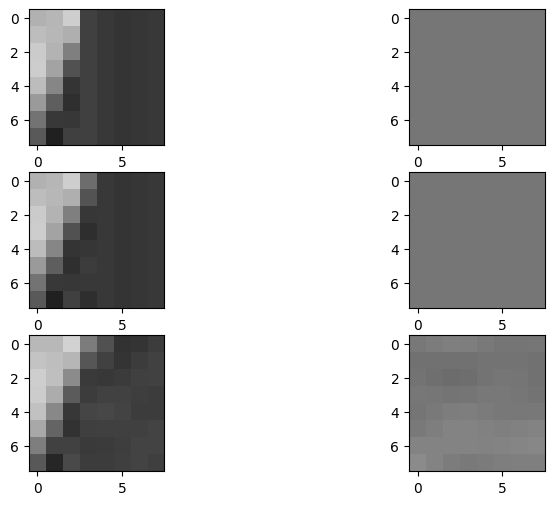

In [ ]:
transformed_block_a[abs(transformed_block_a) <= 20] = 0
transformed_block_b[abs(transformed_block_b) <= 20] = 0

print("Compressed Transformed Block A:\n", transformed_block_a)
print("Compressed Transformed Block B:\n", transformed_block_b)

# @title
block_a_est2 = np.matmul(P, transformed_block_a)
block_b_est2 = np.matmul(P, transformed_block_b)

plt.figure(figsize=(9, 6))
plt.subplot(3, 2, 1)
plt.imshow(block_a_est2, cmap = "gray", vmin = 0, vmax = 255)

plt.subplot(3, 2, 2)
plt.imshow(block_b_est2, cmap = "gray", vmin = 0, vmax = 255)

plt.subplot(3, 2, 3)
plt.imshow(block_a_est, cmap = "gray", vmin = 0, vmax = 255)

plt.subplot(3, 2, 4)
plt.imshow(block_b_est, cmap = "gray", vmin = 0, vmax = 255)

plt.subplot(3, 2, 5)
plt.imshow(block_a_lum, cmap = "gray", vmin = 0, vmax = 255)

plt.subplot(3, 2, 6)
plt.imshow(block_b_lum, cmap = "gray", vmin = 0, vmax = 255)

plt.show()

We see that we're going to lose some sharpness along that roofline (top-left). We can also see that, at both of our chosen thresholds, the luminance of the image on the right (the grass) is constant. While there wasn't much pixel color variation over this patch, we've completely lost the detail.

The JPEG compression algorithm runs a change of basis again, but this time on the rows of the $8\times 8$ patch. Similarly, if this already compressed luminance doesn't vary much across the rows, then we can compress the image further by zeroing out small "fourier" coefficients before translating back to the original image.

We start by converting our `block_a_est` and `block_b_est` rows into their fourier-like coefficients using the discrete cosine transform. We'll do this by multiplying `P_inv` and the transpose of the estimated blocks. We then compress by rounding small entries to $0$, and transform back to obtain a new estimate of the blocks which require potentially even fewer non-zero integers to be stored. Do this in the code cells below, calling your results `block_a_est_transformed` and `block_b_est_transformed`.

In [ ]:
#Calculate and print the transformations of the estimated block a and b


Transformed Block A:
 [[112. 106.  98.  90.  81.  72.  63.  57.]
 [ 80.  77.  72.  63.  49.  32.  15.   5.]
 [ 13.  25.  39.  44.  39.  26.  14.   7.]
 [-26. -12.   6.  20.  24.  19.  12.   7.]
 [-17. -14.  -7.   2.  11.  14.  12.   8.]
 [  4.  -2.  -7.  -7.  -2.   4.   8.   9.]
 [ 12.   8.   2.  -4.  -6.  -2.   5.  11.]
 [  7.   7.   5.   0.  -4.  -3.   3.  10.]]
Transformed Block B:
 [[118. 118. 118. 118. 118. 118. 118. 118.]
 [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
 [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]]


In [ ]:
#Perform the compression and print out the results


Newly Compressed Transformed Block A:
 [[112. 106.  98.  90.  81.  72.  63.  57.]
 [ 80.  77.  72.  63.  49.  32.  15.   0.]
 [ 13.  25.  39.  44.  39.  26.  14.   0.]
 [-26. -12.   0.  20.  24.  19.  12.   0.]
 [-17. -14.   0.   0.  11.  14.  12.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [ 12.   0.   0.   0.   0.   0.   0.  11.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]]
Newly Compressed Transformed Block B:
 [[118. 118. 118. 118. 118. 118. 118. 118.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]]


We see many more non-zero entries in the newly estimated version of Block A than there were in the original. This indicates that most of the variation in luminance occurs horizontally within this block. Visual inspection confirms that. Unsurprisingly, Block B still contains very few non-zero entries.

Now lets convert from these doubly-compressed matrices of fourier-like entries back to our original luminance values. To do this, we'll need to remember that our fourier-like matrix is in its transposed form. We'll multiply this with $P$ and then transpose the result. Mathematically, what we've done is below:

$$\hat{X} = \left(P\left(P^{-1}X^T\right)\right)^T$$

We don't directly recover the original matrix of luminance values $X$ because of the compression (zeroing out) steps we take. Use the code cells to convert the resulting transformed blocks back to the luminance scale, calling the results `block_a_est2` and `block_b_est2`.

I'll plot the results for you below.

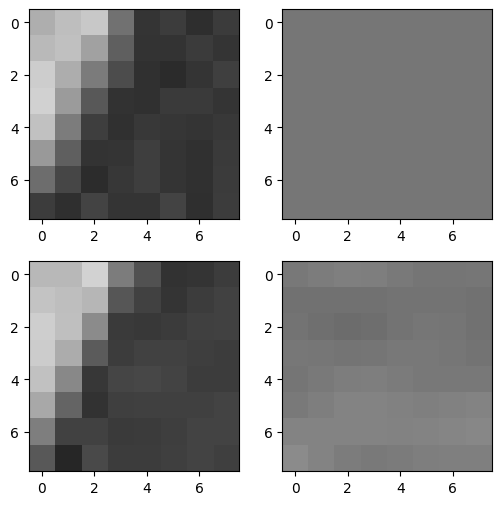

In [ ]:
# @title
plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.imshow(block_a_est2, cmap = "gray", vmin = 0, vmax = 255)

plt.subplot(2, 2, 2)
plt.imshow(block_b_est2, cmap = "gray", vmin = 0, vmax = 255)

plt.subplot(2, 2, 3)
plt.imshow(block_a_lum, cmap = "gray", vmin = 0, vmax = 255)

plt.subplot(2, 2, 4)
plt.imshow(block_b_lum, cmap = "gray", vmin = 0, vmax = 255)

plt.show()

We've seen how the JPEG compression algorithm works on a single $8\times 8$ block of pixels in an image. Now, let's run it over the entire image and see the result. Inspect the function below and connect the procedure back to the steps we've explored on our two sample blocks.

In [ ]:
def jpeg_compress_manual(image, threshold=5):
    height, width, _ = image.shape
    #assert height % 8 == 0 and width % 8 == 0, "Image dimensions must be divisible by 8."
    #clip the image for convenience
    height = height - (height % 8)
    width = width - (width % 8)
    orig_height = image.shape[0]
    orig_width = image.shape[1]
    image = image[:height, :width]

    #Convert to luminance/chrominance
    image_ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    Y = image_ycrcb[:, :, 0]  # luminance to be compressed
    Cr = image_ycrcb[:, :, 1]
    Cb = image_ycrcb[:, :, 2]

    P = np.zeros((8, 8))
    for i in list(range(0, 8)):
      for j in list(range(0, 8)):
        P[i, j] = np.cos((2*i + 1)*j*np.pi/16)

    P_inv = np.linalg.inv(P)

    compressed_Y = np.zeros_like(Y, dtype=np.float32)

    total_coeffs = 0
    kept_coeffs = 0

    for i in range(0, height, 8):
        for j in range(0, width, 8):
            block = Y[i:i+8, j:j+8].astype(np.float32)

            # Apply DCT to columns: F = P^{-1} * block
            F = np.matmul(P_inv, block)
            total_coeffs = total_coeffs + F.size

            # Threshold small values
            F[np.abs(F) < threshold] = 0
            kept_coeffs = kept_coeffs + np.count_nonzero(F)

            # Reconstruct: block_approx = Pinv * F * Pinv^T
            block_approx = np.matmul(P, F)

            # Apply DCT to rows F = P^{-1} * (block_est)^T
            F = np.matmul(P_inv, block_approx)
            total_coeffs = total_coeffs + F.size

            # Threshold small values
            F[np.abs(F) < threshold] = 0
            kept_coeffs = kept_coeffs + np.count_nonzero(F)

            # Reconstruct: block_approx = Pinv * F * Pinv^T
            block_approx = np.matmul(P, F)

            # Clip to valid pixel range and insert into compressed image
            compressed_Y[i:i+8, j:j+8] = np.clip(block_approx, 0, 255)

    image_ycrcb[:, :, 0] = compressed_Y.astype(np.uint8)
    compressed_image = cv2.cvtColor(image_ycrcb, cv2.COLOR_YCrCb2RGB)

    original_bits = height * width * 8
    #compressed_bits = original_bits - (np.count_nonzero(compressed_image) * 8)
    est_compression_ratio = total_coeffs / kept_coeffs

    print(f"Original image dimensions: {orig_height} by {orig_width} pixels")
    print(f"Trimmed image dimensions: {height} by {width} pixels")
    print(f"Trimmed image size: {original_bits} bits")
    print(f"Estimated compression ratio: {est_compression_ratio:.2f}")
    print(f"Estimated compressed bits: {round(original_bits/est_compression_ratio, 0)}")

    return compressed_image.astype(np.uint8)


Use different thresholds to explore the impact that the level of compression we use has on our ability to reconstruct the image. Do larger threshold values or smaller ones correspond to greater levels of compression?

Original image dimensions: 1000 by 1500 pixels
Trimmed image dimensions: 1000 by 1496 pixels
Trimmed image size: 11968000 bits
Estimated compression ratio: 7.84
Estimated compressed bits: 1526776.0


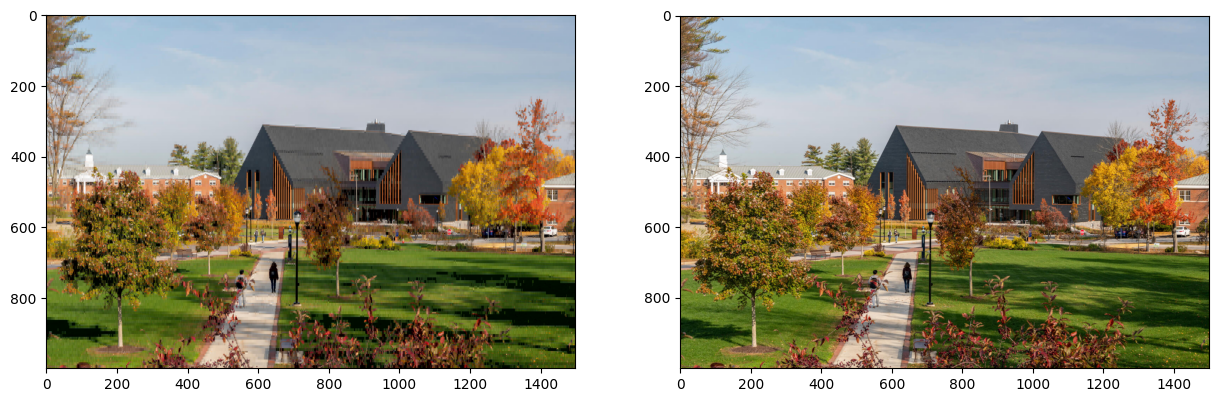

In [ ]:
seta_img_compressed = jpeg_compress_manual(seta_img, threshold = 40)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(seta_img_compressed)

plt.subplot(1, 2, 2)
plt.imshow(seta_img)

plt.show()

#### Some Notes

**Note:** In this implementation, we've only compressed the **luminance (brightness)** channel and left the **chrominance (color)** channels untouched. JPEG achieves much of its compression by reducing the resolution of chrominance data, since the human eye is less sensitive to color than brightness.

Also, the algorithm we've written applies DCT and thresholding in **two separate steps** (first column-wise, then row-wise). In real JPEG compression, a **2D DCT** is applied all at once, which is more efficient and avoids duplicate work. Our version is less efficient, but makes the logic of the transformation easier to see and understand.